<a href="https://colab.research.google.com/github/SeongwonTak/TIL_swtak/blob/master/DLBasic/IntroDLwithPytorch05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SoftMax 회귀
SoftMax Regression이란, 3개 이상의 선택지로부터 1개를 선택하는 다중 클래스 분류 문제를 푸는 방법이다.  
출처 : https://wikidocs.net/59425


## One-Hot Encoding
원-핫 인코딩은 선택해야 하는 선택지의 개수만큼 차원을 가진다.  
각 선택지의 인덱스에 해당되는 원소에는 1, 나머지는 0의 값을 가지게 한다.  

ex) 강아지, 고양이, 냉장고  
강아지 = [1, 0, 0]  
고양이 = [0, 1, 0]  
냉장고 = [0, 0, 1]  

대부분의 다중 클래스 분류 문제는 **각 클래스간의 관계가 균등하다는 점에 있어 One-Hot Encoding이 적절한 방법**이다.

즉, 일반적으로 정수형 label을 부여할 경우, 각 선택지간의 유클리드 거리가 달라질 수 있으나, **One-Hot Encoding을 실시할 경우, 오차는 균등**하다.



## 소프트맥스 회귀 vs 로지스틱 회귀
로지스틱 회귀의 경우는 2개중 1개의 경우를 나누는 상황으로, Yes / No의 확률의 합이 1이 된다. Point는, 확률의 합이 1이 된다라는 의미이다.

소프트맥스 회귀의 경우에도 여전히 **확률의 총합이 1이 되어야 한다.**  즉, 각 선택지가 정답일 확률이 표현된다.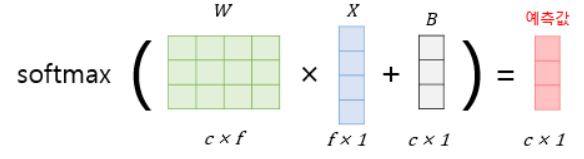

다음과 같은 방식으로 구현을 하게 된다.
- c : number of class
- f : number of features

가중치 벡터 W랑, 편향 b를 학습시켜야 하는 것이 목표다.


여기서 softmax는 확률의 값을 돌려줘야 하는데,
k차원의 벡터에서 i번째 원소가 zi, i번째가 정답일 확률이 pi일 경우,
$$p_{i} = \frac{e^{z_{i}}}{\sum_{j=1}^{k}e^{z_{j}}} $$

### 소프트맥스 회귀의 비용함수
소프트맥스의 회귀는 비용함수로 Cross Entropy 함수를 사용한다. 우선 데이터가 1개일 때의 비용함수는 다음과 같이 정의한다.

$$ cost(W) = -\sum_{j=1}^{k} y_{j}log(p_{j}) $$

여기서 $y_{j}$는 one-hot의 실제 값, p_j는 sample벡터가 j번째 class일 확률이다.  
이진분류의 cross entropy와 본질적으로 동일하다.

여기서, sample 개수 만큼 더해 평균을 낸것이 최종 비용함수가 된다.

In [ ]:
# 구현
import torch
import torch.nn.functional as F

In [ ]:
z = torch.FloatTensor([1, 2, 3])
hypo = F.softmax(z, dim = 0)
print(hypo)

tensor([0.0900, 0.2447, 0.6652])


비용함수를 위해 임의의 텐서를 만들어 소프트맥스 함수를 적용해보려고 한다.

In [ ]:
z = torch.rand(3, 5, requires_grad=True)
hypo = F.softmax(z, dim = 1)  # 각 행별로 softmax를 적용해야 해서, dim = 1이라 표기한다.
print(hypo)

tensor([[0.1888, 0.1745, 0.2073, 0.2480, 0.1814],
        [0.1891, 0.1301, 0.3468, 0.1531, 0.1809],
        [0.1449, 0.2409, 0.1794, 0.1563, 0.2785]], grad_fn=<SoftmaxBackward>)


각 sample에 대해서 label을 만들어야 한다.

In [ ]:
y = torch.randint(5,(3,)).long()
print(y)

tensor([0, 2, 4])


In [ ]:
# one-hot  실시
y_one_hot = torch.zeros_like(hypo)
y_one_hot.scatter_(1, y.unsqueeze(1), 1)

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.]])

In [ ]:
cost = (y_one_hot * -torch.log(hypo)).sum(dim=1).mean()
print(cost)

tensor(1.3349, grad_fn=<MeanBackward0>)


조금 더 내장함수(?)를 사용한 방법을 알아보자.
먼저, Pytorch에는 F.log_softmax()라는 함수가 존재한다.

In [ ]:
F.log_softmax(z, dim=1)

tensor([[-1.6673, -1.7459, -1.5735, -1.3943, -1.7069],
        [-1.6654, -2.0392, -1.0590, -1.8766, -1.7100],
        [-1.9314, -1.4234, -1.7180, -1.8563, -1.2784]],
       grad_fn=<LogSoftmaxBackward>)

또한 비용함수또한 구현되어 있다. **One-hot을 할거 없이 바로 실제 값을 인자로 사용한다.**

In [ ]:
F.nll_loss(F.log_softmax(z, dim=1), y)

tensor(1.3349, grad_fn=<NllLossBackward>)

그런데, 더 극단적으로 F.Cross_entropy를 사용하여 한번에 오차값을 확인 가능하다.
여기서 이 함수의 경우는 softmax와 nll_loss를 한번에 포함하고 있다. 즉, 그냥 바로 하면 된다.  softmax를 포함함을 잊지 말자.

In [ ]:
F.cross_entropy(z, y)

tensor(1.3349, grad_fn=<NllLossBackward>)

## 소프트맥스 회귀의 구현

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
# 훈련 데이터 선언
x_train = [[1, 2, 1, 1],
           [2, 1, 3, 2],
           [3, 1, 3, 4],
           [4, 1, 5, 5],
           [1, 7, 5, 5],
           [1, 2, 5, 6],
           [1, 6, 6, 6],
           [1, 7, 7, 7]]
y_train = [2, 2, 2, 1, 1, 1, 0, 0]
x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)

### F.cross_entropy 사용
즉, 소프트맥스 함수를 사용할 이유가 없다

In [ ]:
# 모델 초기화
W = torch.zeros((4, 3), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
# optimizer 설정
optimizer = optim.SGD([W, b], lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # Cost 계산
    z = x_train.matmul(W) + b
    cost = F.cross_entropy(z, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 1.098612
Epoch  100/1000 Cost: 0.761050
Epoch  200/1000 Cost: 0.689991
Epoch  300/1000 Cost: 0.643229
Epoch  400/1000 Cost: 0.604117
Epoch  500/1000 Cost: 0.568256
Epoch  600/1000 Cost: 0.533922
Epoch  700/1000 Cost: 0.500291
Epoch  800/1000 Cost: 0.466908
Epoch  900/1000 Cost: 0.433507
Epoch 1000/1000 Cost: 0.399962


### nn.Module로 SoftMax 함수 구현

In [ ]:
# 4개의 특성, 3개의 클래스로 분류한다.
model = nn.Linear(4, 3)

In [ ]:
# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    prediction = model(x_train)

    # cost 계산
    cost = F.cross_entropy(prediction, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 20번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 3.013958
Epoch  100/1000 Cost: 0.630261
Epoch  200/1000 Cost: 0.552049
Epoch  300/1000 Cost: 0.499650
Epoch  400/1000 Cost: 0.456268
Epoch  500/1000 Cost: 0.417340
Epoch  600/1000 Cost: 0.380705
Epoch  700/1000 Cost: 0.344925
Epoch  800/1000 Cost: 0.308894
Epoch  900/1000 Cost: 0.272352
Epoch 1000/1000 Cost: 0.242887


## Example : MNIST 손글씨 분류문제

### 문제의 개요
이 데이터셋은 0~9까지의 이미지로 구성된 손글씨 데이터이다. 손글씨로 적힌 이미지가 들어오면 그 이미지가 무슨 숫자인지 맞혀야 한다. 

데이터는 28 * 28 픽셀의 이미지로 구성되어있다. 즉, 각 이미지는 784개의 원소를 가진 벡터로 구성 가능하다. 즉, 784개의 특성을 가진 sample이 된다.

우선 2차원 그림을 1차원 벡터로 만드는 법은 다음과 같다.

In [ ]:
for X, Y in data_loader:
  # 입력 이미지를 [batch_size × 784]의 크기로 reshape
  # 레이블은 원-핫 인코딩
  X = X.view(-1, 28*28)

### 사전 설정

In [ ]:
# 필요한 패키지 import
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

In [ ]:
# hyperparameters
training_epochs = 15
batch_size = 100

In [ ]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# dataset loader
data_loader = DataLoader(dataset=mnist_train,
                                          batch_size=batch_size, # 배치 크기는 100
                                          shuffle=True,
                                          drop_last=True)

Remark. Drop last는 Batch 후 나머지 개수에 대해서 나머지를 버리는 방법이다...

In [ ]:
# MNIST data image of shape 28 * 28 = 784
linear = nn.Linear(784, 10, bias=True)

### 모델

In [ ]:
# 비용 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss() # 내부적으로 소프트맥스 함수를 포함하고 있음.
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)

In [ ]:
for epoch in range(training_epochs): # 앞서 training_epochs의 값은 15로 지정함.
    avg_cost = 0
    total_batch = len(data_loader)

    for X, Y in data_loader:
        # 배치 크기가 100이므로 아래의 연산에서 X는 (100, 784)의 텐서가 된다.
        X = X.view(-1, 28 * 28)
        # 레이블은 원-핫 인코딩이 된 상태가 아니라 0 ~ 9의 정수.
        Y = Y

        optimizer.zero_grad()
        hypothesis = linear(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 0.534868240
Epoch: 0002 cost = 0.359385937
Epoch: 0003 cost = 0.331310660
Epoch: 0004 cost = 0.316333860
Epoch: 0005 cost = 0.307023048
Epoch: 0006 cost = 0.300178707
Epoch: 0007 cost = 0.294964015
Epoch: 0008 cost = 0.290768027
Epoch: 0009 cost = 0.287354171
Epoch: 0010 cost = 0.284431577
Epoch: 0011 cost = 0.282011002
Epoch: 0012 cost = 0.279439688
Epoch: 0013 cost = 0.277816802
Epoch: 0014 cost = 0.276116490
Epoch: 0015 cost = 0.274442345
Learning finished
